VAE: Variational Autoencoder for 2 Gaussian distributions




In [157]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable

In [158]:
import os
from collections import defaultdict
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision.utils import make_grid

In [159]:
def visualize_2d_data(train_data, test_data, train_labels=None, test_labels=None):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  ax1.set_title('train')
  ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
  ax2.set_title('test')
  ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
  plt.show()

In [160]:
def generate_2d_data(count,mode='univariate'):
  assert mode in['univariate','multivariate']
  np.random.seed(42)
  mean = [[2.0,3.0]]
  sigma = [[3.0,1.0]]

  if mode == "univariate":
    rotate = [[1.0,0.0],[0.0,1.0]]

  else:
    rotate = [[np.sqrt(2) / 2, np.sqrt(2) / 2],[-np.sqrt(2) / 2, np.sqrt(2) / 2]]

  data =  mean + (np.random.randn(count,2)*sigma).dot(rotate)
  #data = mean + (sigma*sps.multivariate_normal(mean = [0.0,0.0], cov = [[1.0,0.0],[0.0,1.0]]).rvs(count)).dot(rotate)
  data = data.astype("float32")

  split=int(0.8*count)
  train_data,test_data = data[:split],data[split:]
  return train_data,test_data

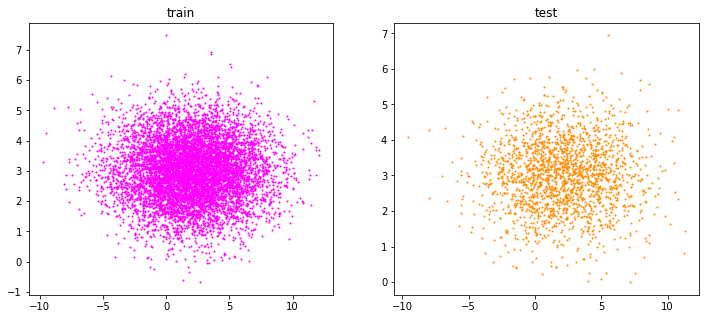

In [161]:
count = 10000

train_data,test_data = generate_2d_data(count,'univariate' )
visualize_2d_data(train_data,test_data,train_labels = "magenta",test_labels = "darkorange")

In [29]:
def visualize_2d_samples(data,title):
  fig,ax = plt.subplots(figsize=(5,5))
  ax.set_title(title)
  ax.scatter(data[:,0],data[:,1],s=1)
  plt.show()

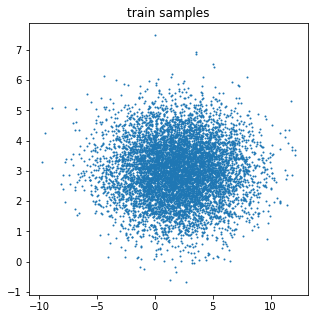

In [30]:
visualize_2d_samples(train_data, "train samples")

In [31]:
def plot_training_curves(train_losses, test_losses):
  n_train = len(train_losses[list(train_losses.keys())[0]])
  n_test = len(test_losses[list(train_losses.keys())[0]])
  x_train = np.linspace(0, n_test - 1, n_train)
  x_test = np.arange(n_test)

  plt.figure()
  for key, value in train_losses.items():
    plt.plot(x_train, value, label=key + '_train')

  for key, value in test_losses.items():
    plt.plot(x_test, value, label=key + '_test')

  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

In [32]:
def train_epoch(model, train_loader,optimizer,epoch,loss_key):
  model.train()
  stats = defaultdict(list)
  for x in train_loader:
    #x = Variable(x)# cuda
    optimizer.zero_grad()
    losses = model.loss(x)
    losses[loss_key].backward()
    optimizer.step()

    for k,v in losses.items():
      stats[k].append(v.item())
  return stats


In [33]:
def eval_model(model, data_loader):
  model.eval()
  stats = defaultdict(float)
  with torch.no_grad():
    for x in data_loader:
      #x = Variable(x)
      if False:
        x = x.cuda()
      losses = model.loss(x)
      for k,v in losses.items():
        stats[k]+=v.item()*x.shape[0]
    
    for k in stats.keys():
      stats[k] /= len(data_loader.dataset)
  return stats

In [34]:
def train_model(model, train_loader, test_loader, epochs, lr, loss_key):
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  train_losses = defaultdict(list)
  test_losses =  defaultdict(list)
  for epoch in range(epochs):
    model.train()
    train_loss = train_epoch(model,train_loader,optimizer,epoch,loss_key)
    test_loss = eval_model(model,test_loader)

    for k in train_loss.keys():
      train_losses[k].extend(train_loss[k])
      test_losses[k].append(test_loss[k])
  return dict(train_losses), dict(test_losses)

In [35]:
class FullyConnectedMLP(nn.Module):
  def __init__(self, input_shape, hiddens, output_shape):

    assert isinstance(hiddens, list)
    super().__init__()
    self.input_shape = (input_shape,)
    self.output_shape = (output_shape,)
    self.hiddens = hiddens

    # Stack some fully connected layers wirh relu activation.
    # Note that you do not have to add relu after the last fc layer
    self.net = []
    hidden_sizes = [input_shape] + hiddens + [output_shape]
    for layer_current, layer_next in zip(hidden_sizes,hidden_sizes[1:]):
      self.net.extend([nn.Linear(in_features=layer_current,out_features=layer_next), nn.ReLU()])
    self.net.pop() #remove final relu activational function
    self.net = nn.Sequential(*self.net)

  def forward(self, x):
    return self.net(x)

In [197]:
class VAE2d(nn.Module):
  def __init__(self,n_in,n_latent,enc_hidden_sizes,dec_hidden_sizes):
    
    assert isinstance(enc_hidden_sizes,list)
    assert isinstance(dec_hidden_sizes,list)

    super(VAE2d,self).__init__()
    self.n_latent = n_latent
    self.encoder = FullyConnectedMLP(n_in,enc_hidden_sizes,2*n_latent) # return parameters of distribution
    self.decoder = FullyConnectedMLP(n_latent,dec_hidden_sizes, 2*n_in) # return parameters of distribution


  
  def prior(self,n):
    return torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2),torch.eye(2)).rsample(torch.tensor([n]))

  def forward(self,x):
    mu_z,log_std_z = self.encoder(x).chunk(2,dim = 1)
    z = torch.randn_like(mu_z)*log_std_z.exp() + mu_z # reparametrization trick
    mu_x,log_std_x = self.decoder(z).chunk(2, dim= 1)
    return mu_z,log_std_z,mu_x,log_std_x
  
  def loss(self, x):
    mu_z,log_std_z,mu_x,log_std_x = model(x) # model(x)
    # for example mu_z = torch.tensor([[.. , ..], [.. , ..], ... ,[.. , ..]],gradfn=< >)
    # reconstruction loss is just logarithm of normal density distribution density 
    #print(mu_x,log_std_x,x)
    #print(mu_x,log_std_x,x)
    """
    recon_loss = torch.tensor([0.])
    for idx in range(x.shape[0]):
      recon_loss = torch.cat([recon_loss,\
                              torch.distributions.multivariate_normal.MultivariateNormal(mu_x[idx,:],torch.mul(log_std_x[idx,:].exp(),torch.eye(2))).log_prob(x[idx]).reshape(-1)])
    recon_loss = recon_loss[1:]
    recon_loss = recon_loss.reshape(-1,1)
    recon_loss = recon_loss.sum(1).mean() 
    """
    recon_loss = 0.5 * ( (x - mu_x).pow(2)/log_std_x.exp() + log_std_x ) # torch.log(torch.tensor([2*pi])) - is a constant , doesn't influence on a convergenxe
    recon_loss = recon_loss.sum(1).mean()
        
    # kl divergence of two normal distribution has analytic expression
    # https://jhui.github.io/2017/03/06/Variational-autoencoders/
    kl_loss = 0.5*(mu_z.pow(2) - 1 + log_std_z.exp()- log_std_z) 
    kl_loss = kl_loss.sum(1).mean()  # averaging through batch

    return {
      'elbo_loss': recon_loss + kl_loss, 
      'recon_loss': recon_loss,
      'kl_loss': kl_loss
    }



  
  
  def sample(self,n,noise=True):
    with torch.no_grad():
      z = self.prior(n)
      mu,log_std = self.decoder(z).chunk(2, dim = 1)
      if noise:# what noise?
        z= torch.randn_like(mu)*log_std.exp() + mu
      else:
        z= mu
    return z.cpu().numpy()


In [198]:
def solve_task(train_data, test_data, model, batch_size, epochs, lr):
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

  train_losses, test_losses = train_model(
      model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
  )
  samples_noise = model.sample(1000, noise=True)
  samples_nonoise = model.sample(1000, noise=False)

  for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))

  plot_training_curves(train_losses, test_losses)
  visualize_2d_samples(samples_noise, title='Samples with Decoder Noise')
  visualize_2d_samples(samples_nonoise, title='Samples without Decoder Noise')

In [199]:
ENC_HIDDEN_SIZES = [4,8]
DEC_HIDDEN_SIZES = [4,8]
BATCH_SIZE = 100
EPOCHS = 4
LR = 1e-3
COUNT = 10000

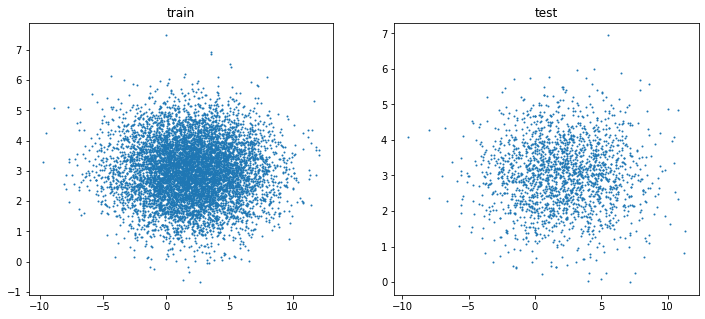

elbo_loss: 2.9187
recon_loss: 2.7517
kl_loss: 0.1670


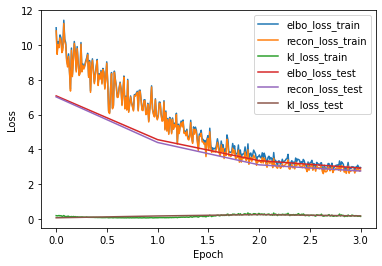

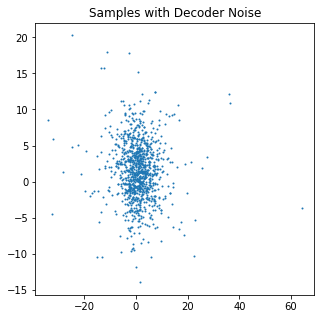

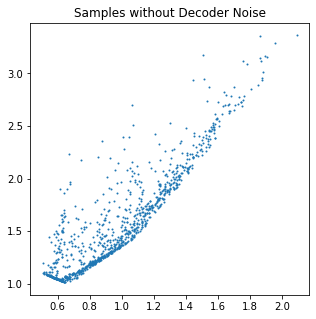

In [200]:
train_data, test_data = generate_2d_data(COUNT, mode='univariate')
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES)
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR)

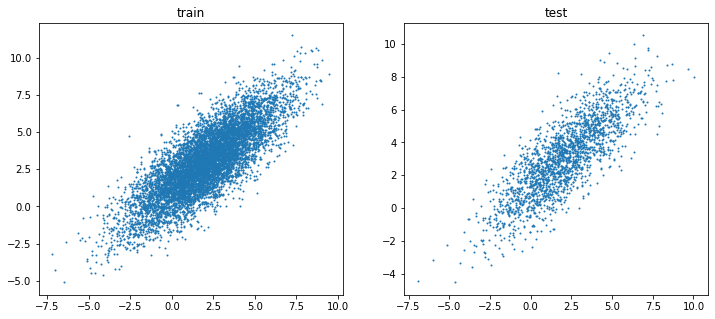

elbo_loss: 2.8736
recon_loss: 2.6793
kl_loss: 0.1943


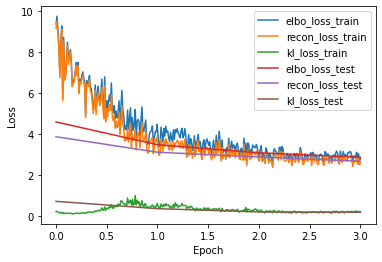

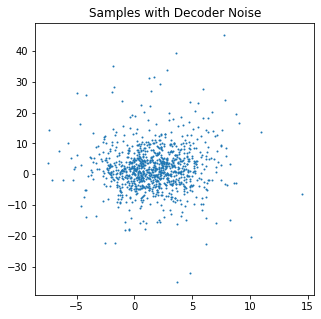

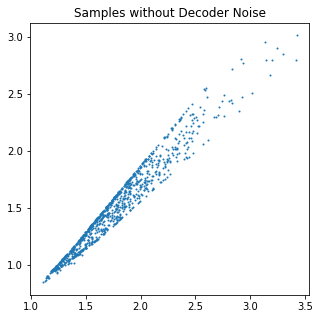

In [203]:
train_data, test_data = generate_2d_data(COUNT, mode='multivariate')
visualize_2d_data(train_data, test_data)

model = VAE2d(2, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES) #.cuda()
solve_task(train_data, test_data, model, BATCH_SIZE, EPOCHS, LR)